# 1. Introduction

## 1.1 The Dataset

The dataset consists of 220 rows and several columns, with the following variables:

- **Y:** Binary variable with 2 levels (absence (n) or presence (y)).
- **Ap:** Categorical variable with 2 levels (active or placebo).
- **Hilo:** Categorical variable with 2 levels (hi or low compliance).
- **Week:** Categorical variable with 5 levels representing the week of the test (0, 2, 4, 6, 11).
- **ID:** Categorical variable with unique identifiers (X01-X21, Y01-Y14, Z01-Z26).
- **Trt:** A recoding of Ap and Hilo, where:
  - If Ap == p, then it's placebo.
  - If Ap == a and Hilo == hi, then it's drug+.
  - If Ap == a and Hilo == lo, then it's drug.
  
Additionally, week and ID are numeric variables.

## 1.2 The Methodology

In this analysis, we employ a Generalized Linear Mixed Model (GLMM) due to the non-normality and correlated nature of the observations. Key aspects of our methodology include:

- Incorporating random effects to account for correlation within the data.
- Modeling the log odds or log mean, depending on the specific research question.

## 1.3 The Research Question
**Primary Question 1:**  
To test the effectiveness of compliance (compliance effectiveness) on the presence of bacteria.

**Primary Question 2:**  
To test the effectiveness of the treatment on the presence of bacteria.

**Primary Question 3:**  
To evaluate how the effectiveness of the treatment behaves over time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import glm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from statsmodels.stats.outliers_influence import OLSInfluence
import arviz as az
import patsy
import pymc3 as pm

# 2. EDA

## 2.1 Summary Statistics

In [2]:
bacteria = pd.read_csv('bacteria.csv')

In [3]:
bacteria.head()

,y,ap,hilo,week,ID,trt
0,y,p,hi,0,X01,placebo
1,y,p,hi,2,X01,placebo
2,y,p,hi,4,X01,placebo
3,y,p,hi,11,X01,placebo
4,y,a,hi,0,X02,drug+


In [4]:
# Display the structure of the DataFrame
print(bacteria.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   y       220 non-null    object
 1   ap      220 non-null    object
 2   hilo    220 non-null    object
 3   week    220 non-null    int64 
 4   ID      220 non-null    object
 5   trt     220 non-null    object
dtypes: int64(1), object(5)
memory usage: 10.4+ KB
None


In [5]:
frequency_table = bacteria['trt'].value_counts().reset_index()
frequency_table.columns = ['Category', 'Frequency']
# Display the frequency table
print(frequency_table)

  Category  Frequency
0  placebo         96
1    drug+         62
2     drug         62


In [6]:
frequency_table = bacteria['ap'].value_counts().reset_index()
frequency_table.columns = ['Category', 'Frequency']
# Display the frequency table
print(frequency_table)

  Category  Frequency
0        a        124
1        p         96


In [7]:
frequency_table = bacteria['week'].value_counts().reset_index()
frequency_table.columns = ['Category', 'Frequency']
# Display the frequency table
print(frequency_table)

   Category  Frequency
0         0         50
1         2         44
2        11         44
3         4         42
4         6         40


In [8]:
frequency_table = bacteria['y'].value_counts().reset_index()
frequency_table.columns = ['Category', 'Frequency']
# Display the frequency table
print(frequency_table)

  Category  Frequency
0        y        177
1        n         43


In [9]:
# Get the column names
print(bacteria.columns)

Index(['y', 'ap', 'hilo', 'week', 'ID', 'trt'], dtype='object')


In [10]:
# Summary statistics
print(bacteria.describe())

             week
count  220.000000
mean     4.454545
std      3.850248
min      0.000000
25%      2.000000
50%      4.000000
75%      6.000000
max     11.000000


## 2.2 Visualization

### 2.2.1 

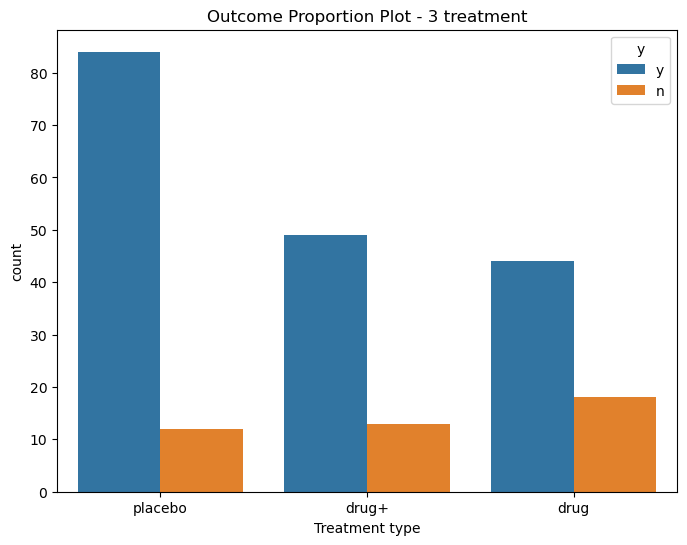

In [11]:
# Outcome Proportion Plot - trt
plt.figure(figsize = (8,6))
sns.countplot(data = bacteria, x = 'trt', hue = 'y')
plt.xlabel("Treatment type")
plt.title("Outcome Proportion Plot - 3 treatment")
plt.show()

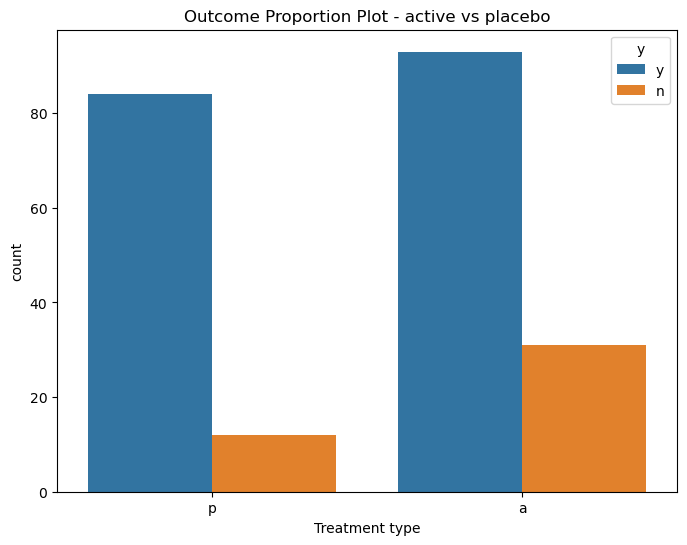

In [12]:
# Outcome Proportion Plot - ap
plt.figure(figsize=(8, 6))
sns.countplot(data=bacteria, x='ap', hue='y')
plt.xlabel("Treatment type")
plt.title("Outcome Proportion Plot - active vs placebo")
plt.show()

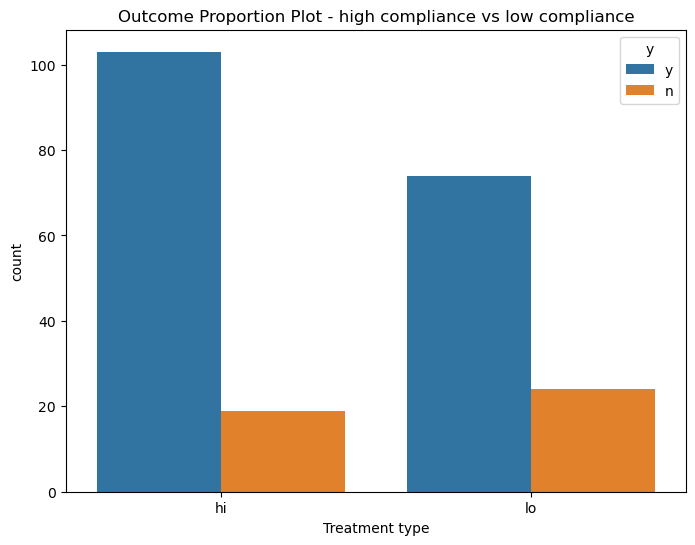

In [13]:
# Outcome Proportion Plot - hilo
plt.figure(figsize=(8, 6))
sns.countplot(data=bacteria, x='hilo', hue='y')
plt.xlabel("Treatment type")
plt.title("Outcome Proportion Plot - high compliance vs low compliance")
plt.show()

### Observations from different treatment groups

In the 'trt' (treatment) group, 'drug' did a better job in reducing the appearance rate of y (bacteria).  
In the 'ap' (active vs placebo) group, 'drug == active' can significantly reduce the appearance rate of y (bacteria) than 'drug == placebo'.  
From the 3rd figure, we can see that 'compliance == low' is slightly better than 'compliance' to reduce the presence of bacteria.

### 2.2.2 

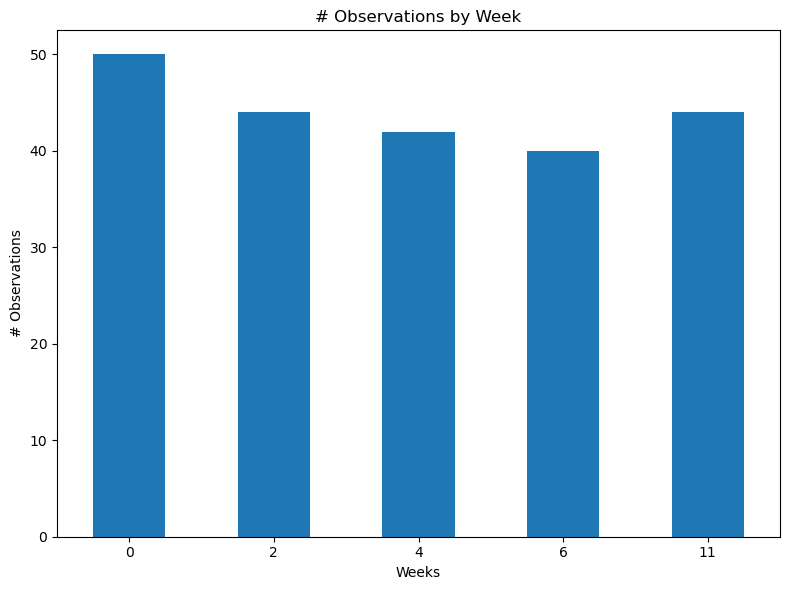

In [14]:
# Summarize observations by week
week_counts = bacteria['week'].value_counts().sort_index()
# Create a bar plot
plt.figure(figsize=(8, 6))
week_counts.plot(kind='bar')
plt.title('# Observations by Week')
plt.xlabel('Weeks')
plt.ylabel('# Observations')
plt.xticks(rotation=0)  # Keep the week labels horizontal
plt.tight_layout()
plt.show()

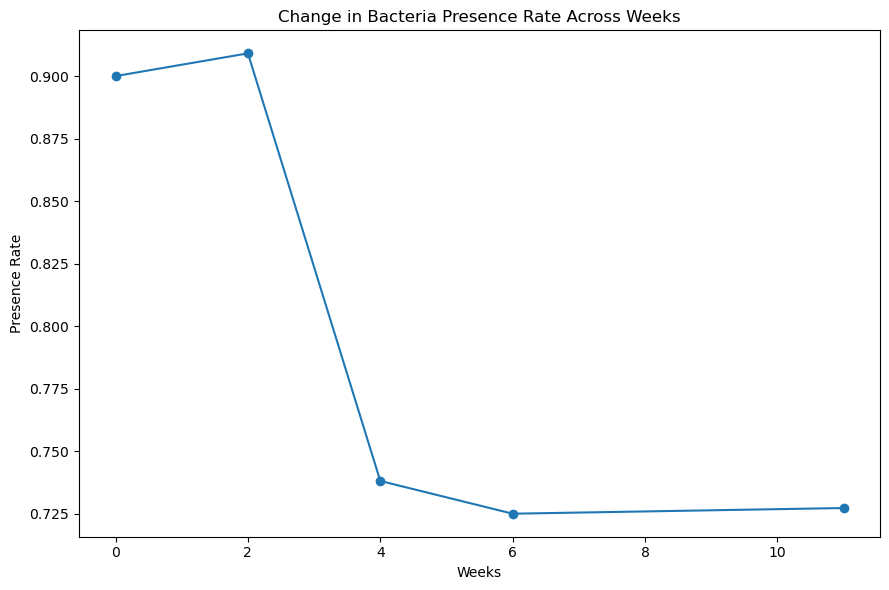

In [15]:
# change in bacteria presense rate across time
presence_rate = bacteria.groupby('week')['y'].apply(lambda x: (x == 'y').mean())

# Create a line plot for the change in presence rate
plt.figure(figsize=(9, 6))
plt.plot(presence_rate, marker='o', linestyle='-')
plt.title('Change in Bacteria Presence Rate Across Weeks')
plt.xlabel('Weeks')
plt.ylabel('Presence Rate')
plt.xticks(rotation=0)  # Keep the week labels horizontal
plt.tight_layout()
plt.show()

### Observations from bacteria present rate change over time
The 1st plot displays the distribution of observations across various weeks, with each bar representing the count for a respective week. It appears that, in general, the frequency of observations varies week by week.  

The 2nd line chart shows that the relationship between time and the presence of bacteria is not perfectly linear, and there's a hugh drop between week == 2 and week == 4.

### 2.2.3 

In [16]:
# Convert 'y' to binary: 0 for 'n' (absence) and 1 for 'y' (presence)
bacteria['y_int'] = [0 if y == 'n' else 1 for y in bacteria['y']]

In [17]:
# Check for 4 combinations based on 'ap' and 'hilo'
interaction_ap_hilo = bacteria.groupby(['ap', 'hilo'])['y_int'].mean().reset_index()
interaction_ap_hilo

,ap,hilo,y_int
0,a,hi,0.790323
1,a,lo,0.709677
2,p,hi,0.900000
3,p,lo,0.833333


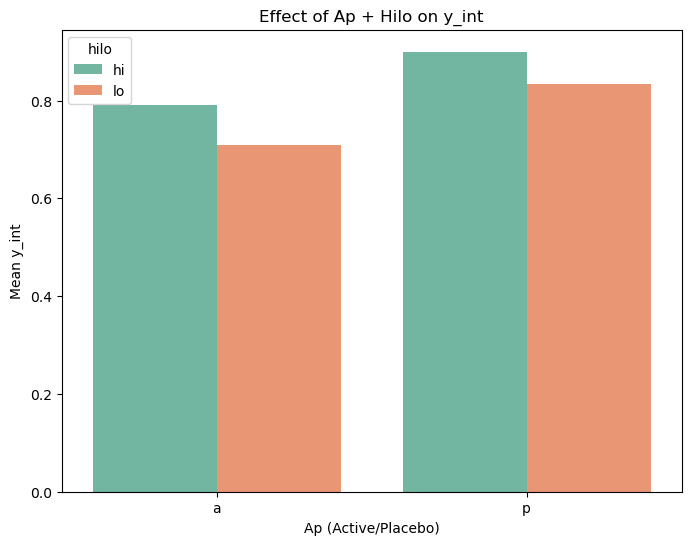

In [18]:

plt.figure(figsize=(8, 6))
sns.barplot(data=interaction_ap_hilo, x='ap', y='y_int', hue='hilo', palette="Set2")
plt.xlabel('Ap (Active/Placebo)')
plt.ylabel('Mean y_int')
plt.title('Effect of Ap + Hilo on y_int')
plt.show()

### Observation
Low compliance and active treatment can best reduce the presence of bacteria.

In [19]:
# Calculate the effect of 'week' + 'trt' on 'y_int'
interaction_week_trt = bacteria.groupby(['week', 'trt'])['y_int'].mean().reset_index()
interaction_week_trt

,week,trt,y_int
0,0,drug,0.857143
1,0,drug+,0.933333
2,0,placebo,0.904762
3,2,drug,0.846154
4,2,drug+,0.909091
5,2,placebo,0.950000
6,4,drug,0.583333
7,4,drug+,0.833333
8,4,placebo,0.777778
9,6,drug,0.545455


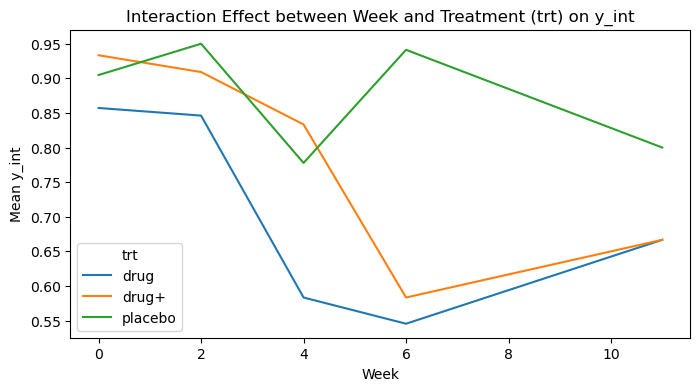

In [20]:
# Create a line plot to visualize the interaction effect
plt.figure(figsize=(8, 4))
sns.lineplot(data=interaction_week_trt, x='week', y='y_int', hue='trt')
plt.xlabel('Week')
plt.ylabel('Mean y_int')
plt.title('Interaction Effect between Week and Treatment (trt) on y_int')
plt.show()

### Observation:
1. In groups that have taken the medication (drug and drug+), the appearance rate of bacteria (y_int) decreases over time, with a more notable decline observed after 2 weeks. This suggests that the medication begins to show its effects after two weeks.
2. The use of drug+ (ap == a & hilo == hi) appears to be less effective than drug in reducing the appearance rate of bacteria (y_int), suggesting that compliance may not be very effective.

In [21]:
bacteria.head()

,y,ap,hilo,week,ID,trt,y_int
0,y,p,hi,0,X01,placebo,1
1,y,p,hi,2,X01,placebo,1
2,y,p,hi,4,X01,placebo,1
3,y,p,hi,11,X01,placebo,1
4,y,a,hi,0,X02,drug+,1


<Figure size 1500x1000 with 0 Axes>

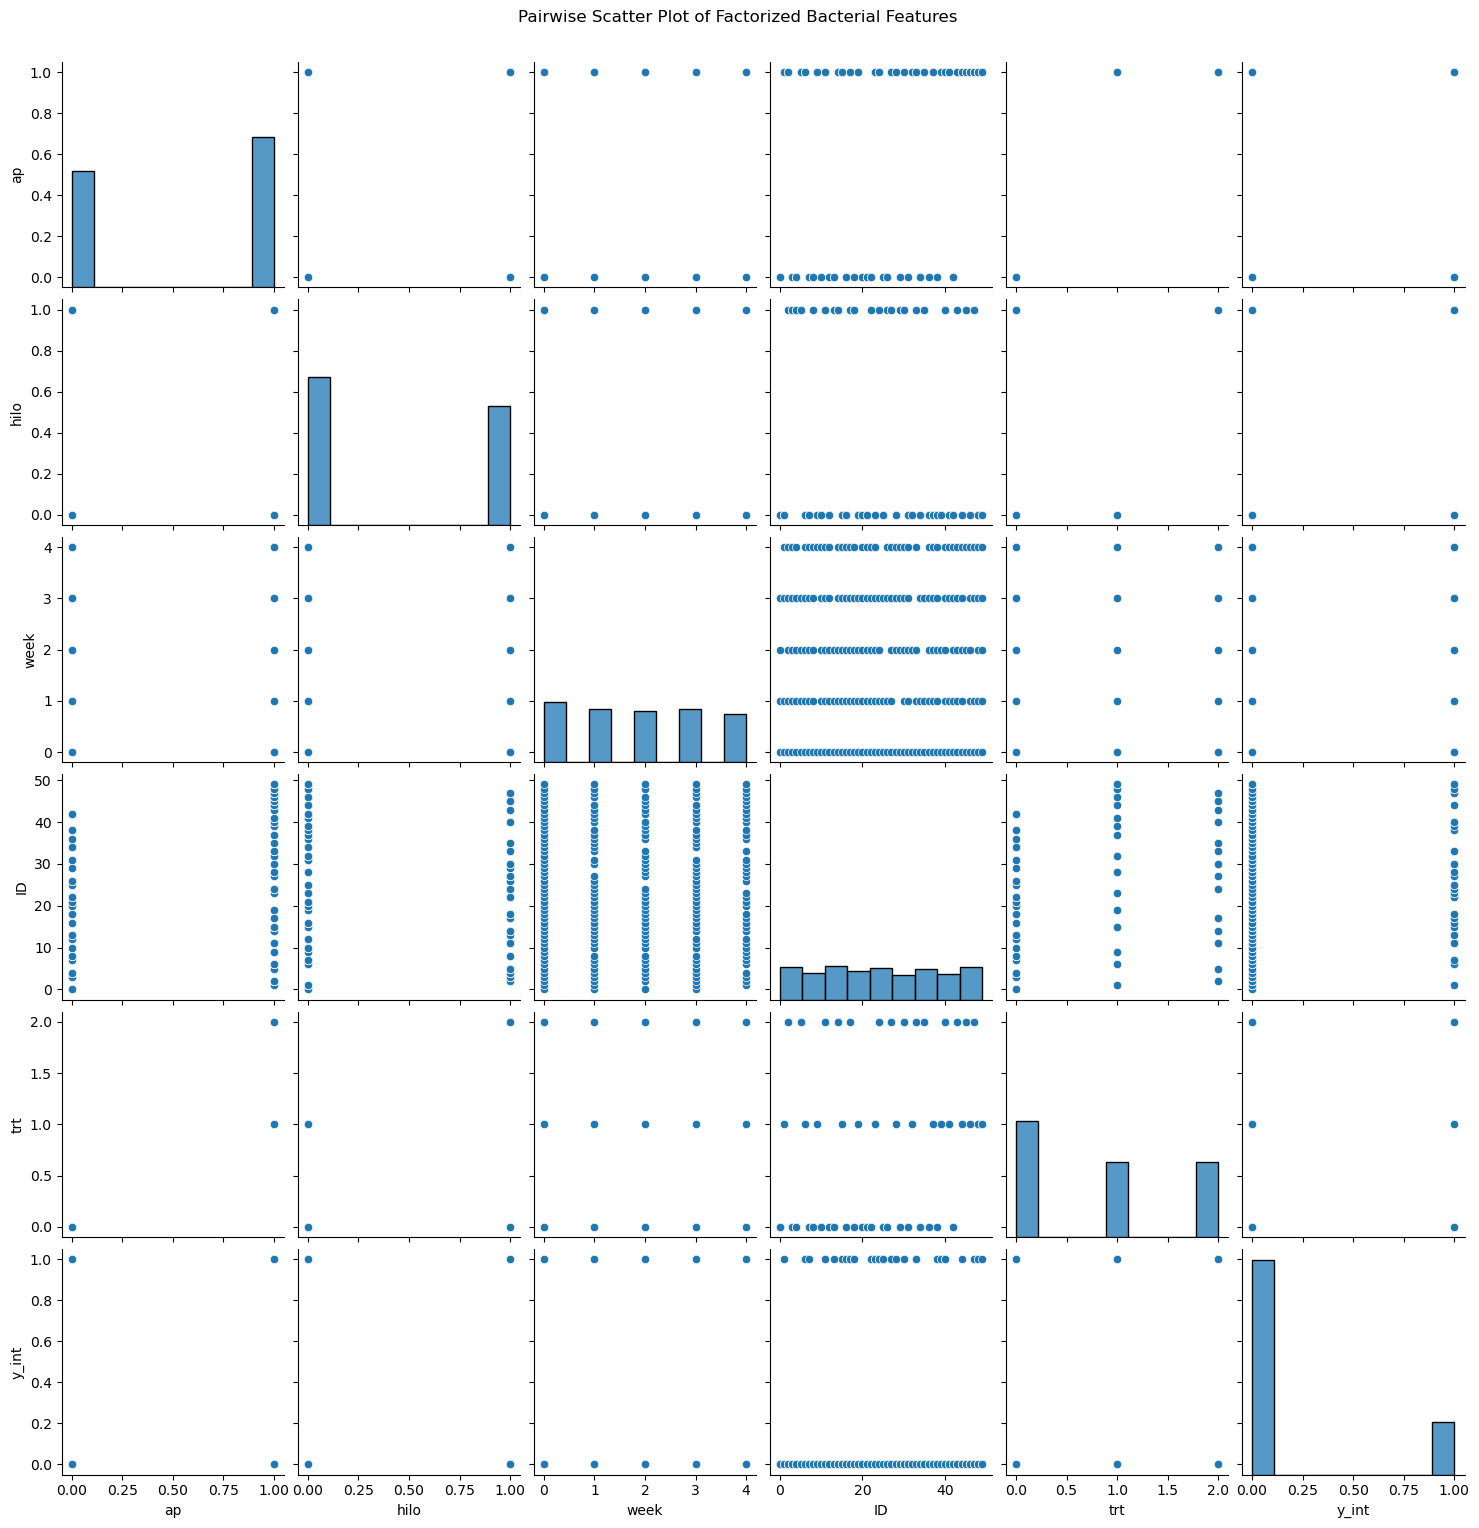

In [22]:
# Drop the target column 'y'
df = bacteria.drop('y', axis=1)

# Factorize all remaining columns
for column in df.columns:
    df[column], _ = pd.factorize(df[column])

# Create a scatter plot matrix
plt.figure(figsize=(15, 10))
sns.pairplot(df)
plt.suptitle('Pairwise Scatter Plot of Factorized Bacterial Features', y=1.02)
plt.show()

# 3. Model

In [23]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(model):
    X = model.model.exog

    vif_data = pd.DataFrame()
    vif_data["Variable"] = model.model.exog_names
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

    return vif_data

In [24]:
bacteria.head()

,y,ap,hilo,week,ID,trt,y_int
0,y,p,hi,0,X01,placebo,1
1,y,p,hi,2,X01,placebo,1
2,y,p,hi,4,X01,placebo,1
3,y,p,hi,11,X01,placebo,1
4,y,a,hi,0,X02,drug+,1


### GLM Part 1 (test the interaction between ap and hilo)

In [25]:
# Fitting the model without the interaction term
model_full_0 = glm(formula='y_int ~ ap + hilo + C(week)', family=sm.families.Binomial(), data=bacteria).fit()
print(model_full_0.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  y_int   No. Observations:                  220
Model:                            GLM   Df Residuals:                      213
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -99.140
Date:                Sat, 17 Feb 2024   Deviance:                       198.28
Time:                        23:23:04   Pearson chi2:                     227.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08314
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.1733      0.529      4.111

In [26]:
calculate_vif(model_full_0)

,Variable,VIF
0,Intercept,6.115698
1,ap[T.p],1.016749
2,hilo[T.lo],1.016108
3,C(week)[T.2],1.505011
4,C(week)[T.4],1.488888
5,C(week)[T.6],1.472811
6,C(week)[T.11],1.504787


In [27]:
import math
math.exp(0.8360)

2.3071200151265554

#### Interpret 2 coefs (***):
The change in the log-odds of y_int when ap = placebo compared to the refernce category (drug == actice) is 0.83.  
The odds of "bacteria == presence" is are 231% greater with "drug == placebo" than "drug == active".

In [28]:
# Fitting the model with the interaction term
model_full_1 = glm(formula='y_int ~ ap + hilo + ap:hilo + C(week)', family=sm.families.Binomial(), data=bacteria).fit()
print(model_full_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  y_int   No. Observations:                  220
Model:                            GLM   Df Residuals:                      212
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -99.130
Date:                Sat, 17 Feb 2024   Deviance:                       198.26
Time:                        23:23:04   Pearson chi2:                     228.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08322
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.1544      0

In [29]:
calculate_vif(model_full_1)

,Variable,VIF
0,Intercept,6.825461
1,ap[T.p],1.778911
2,hilo[T.lo],1.755005
3,C(week)[T.2],1.506299
4,C(week)[T.4],1.488901
5,C(week)[T.6],1.473000
6,C(week)[T.11],1.505193
7,ap[T.p]:hilo[T.lo],2.313645


In [30]:
# ANOVA test to compare the two models
# Compute the likelihood ratio test manually
lr_stat = -2 * (model_full_0.llf - model_full_1.llf)
p_value = chi2.sf(lr_stat, df=1) # df is the difference in the number of parameters between the models

print(f"Likelihood ratio test statistic: {lr_stat}")
print(f"p-value: {p_value}")

Likelihood ratio test statistic: 0.019440416147119777
p-value: 0.8891112421913541


### Observation
the deviance is 0.01944 with a difference of 1 degree of freedom. This value is very small, suggesting that adding the interaction term ap * hilo does not improve the model fit significantly. Also, p-value (0.889) is above significance level (0.05), so we conclude that there is no evidence that the interaction term significantly improves the model.

### GLM Part 2 (test the interaction between ap and C(week))

In [31]:
# Fitting the model with the interaction term
model_full_2 = glm(formula='y_int ~ ap + hilo + ap:C(week) + C(week)', family=sm.families.Binomial(), data=bacteria).fit()
print(model_full_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  y_int   No. Observations:                  220
Model:                            GLM   Df Residuals:                      209
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -96.988
Date:                Sat, 17 Feb 2024   Deviance:                       193.98
Time:                        23:23:04   Pearson chi2:                     226.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1009
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.45

In [32]:
calculate_vif(model_full_2)

,Variable,VIF
0,Intercept,8.546602
1,ap[T.p],4.452959
2,hilo[T.lo],1.017960
3,C(week)[T.2],2.682748
4,C(week)[T.4],2.587885
5,C(week)[T.6],2.551464
6,C(week)[T.11],2.680656
7,ap[T.p]:C(week)[T.2],3.162177
8,ap[T.p]:C(week)[T.4],2.963764
9,ap[T.p]:C(week)[T.6],2.892988


In [33]:
# ANOVA test to compare the two models
# Compute the likelihood ratio test manually
lr_stat = -2 * (model_full_0.llf - model_full_2.llf)
p_value = chi2.sf(lr_stat, df=4) # df is the difference in the number of parameters between the models

print(f"Likelihood ratio test statistic: {lr_stat}")
print(f"p-value: {p_value}")

Likelihood ratio test statistic: 4.3048284796923895
p-value: 0.3663208628380005


### Observation
P-value (0.366) is more than significance level (0.05), so we conclude that there is no evidence that the interaction term significantly improves the model.

### GLM Part 3 (Feature Selection)

In [34]:
# Fit full model with interaction term
full_model = smf.glm(formula='y ~ ap + hilo + ap:hilo + C(week)', data=bacteria, family=sm.families.Binomial()).fit()

# Print the summary of the model
print(full_model.summary())
print(f"AIC for full_model: {full_model.aic}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:       ['y[n]', 'y[y]']   No. Observations:                  220
Model:                            GLM   Df Residuals:                      212
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -99.130
Date:                Sat, 17 Feb 2024   Deviance:                       198.26
Time:                        23:23:04   Pearson chi2:                     228.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08322
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.1544      0

In [35]:
# Define a function to convert week into a binary indicator where week > 2 is True (or 1) and False (or 0) otherwise.
bacteria['week_gt_2'] = bacteria['week'].apply(lambda x: x > 2)

# # Model with 'hilo' and week as a factor
glm_a1 = glm(formula='y_int ~ ap + C(week)', family=sm.families.Binomial(), data=bacteria).fit()
print(glm_a1.summary())

# Model with 'hilo' and with week > 2 as a factor
glm_a2 = glm('y_int ~ ap + C(week_gt_2)', family=sm.families.Binomial(), data=bacteria).fit()
print(glm_a2.summary())

# Model with 'hilo' and week > 2 as a factor
glm_a3 = glm('y_int ~ ap + hilo + C(week_gt_2)', family=sm.families.Binomial(), data=bacteria).fit()
print(glm_a3.summary())

# Compare AIC values to determine which model is better
# Lower AIC suggests a better model fit, so we choose the one with the lower AIC
print(f"AIC for glm_a1: {glm_a1.aic}")
print(f"AIC for glm_a2: {glm_a2.aic}")
print(f"AIC for glm_a3: {glm_a3.aic}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  y_int   No. Observations:                  220
Model:                            GLM   Df Residuals:                      214
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -100.19
Date:                Sat, 17 Feb 2024   Deviance:                       200.39
Time:                        23:23:04   Pearson chi2:                     225.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07432
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.8977      0.485      3.914

### Observation
This suggests that glm_a3 might be the best-fitting model among the three, given the provided AIC values. However, the difference between glm_a2 and glm_a3 is relatively small.

In [36]:
# GLM with treatment and week as factors, without interaction term
glm_b1 = glm('y_int ~ trt + C(week)', family=sm.families.Binomial(), data=bacteria).fit()
print(glm_b1.summary())

# GLM with treatment and week interaction term
glm_b2 = glm('y_int ~ trt * C(week)', family=sm.families.Binomial(), data=bacteria).fit()
print(glm_b2.summary())

# Model improvement considering week > 2 (latent period not effective yet)
glm_b3 = glm('y_int ~ trt + week_gt_2', family=sm.families.Binomial(), data=bacteria).fit()
print(glm_b3.summary())

# Compare AIC values to determine which model is better
# Lower AIC suggests a better model fit, so we choose the one with the lower AIC
print(f"AIC for glm_b1: {glm_b1.aic}")
print(f"AIC for glm_b2: {glm_b2.aic}")
print(f"AIC for glm_b3: {glm_b3.aic}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  y_int   No. Observations:                  220
Model:                            GLM   Df Residuals:                      213
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -99.563
Date:                Sat, 17 Feb 2024   Deviance:                       199.13
Time:                        23:23:04   Pearson chi2:                     224.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07961
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.6685      0.521      3.

### Observation
The model including the indicator variable for weeks greater than 2 shows a lower AIC, indicating a better fit, and the predictor variables exhibit more statistically significant p-values, demonstrating a stronger and more decisive impact on the outcome.

In [37]:
# Define a function to check for overdispersion
def check_overdispersion(model):
    pearson_chi2 = model.pearson_chi2
    df_resid = model.df_resid
    dispersion = pearson_chi2 / df_resid
    print(f"Dispersion statistic (Pearson chi-squared / df_resid): {dispersion}")
    return dispersion

In [38]:
# GLM with 'ap', 'hilo', and week > 2
# GLM with 'ap' and week > 2
check_a2 = glm('y_int ~ ap + week_gt_2', family=sm.families.Poisson(), data=bacteria).fit()
print(check_a2.summary())
dispersion_a2 = check_overdispersion(check_a2)

check_a3 = glm('y_int ~ ap + hilo + week_gt_2', family=sm.families.Poisson(), data=bacteria).fit()
print(check_a3.summary())
dispersion_a3 = check_overdispersion(check_a3)

# GLM with 'trt' and week > 2
check_b3 = glm('y_int ~ trt + week_gt_2', family=sm.families.Poisson(), data=bacteria).fit()
print(check_b3.summary())
dispersion_b3 = check_overdispersion(check_b3)

# Check if dispersion statistics are greater than the rule of thumb (1.10)
overdispersed_a2 = dispersion_a2 > 1.10
overdispersed_a3 = dispersion_a3 > 1.10
overdispersed_b3 = dispersion_b3 > 1.10
print(f"Dispersion parameter for model_b: {dispersion_a2}, Overdispersed: {overdispersed_a2}")
print(f"Dispersion parameter for model_b: {dispersion_a3}, Overdispersed: {overdispersed_a3}")
print(f"Dispersion parameter for model_b: {dispersion_b3}, Overdispersed: {overdispersed_b3}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  y_int   No. Observations:                  220
Model:                            GLM   Df Residuals:                      217
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -213.97
Date:                Sat, 17 Feb 2024   Deviance:                       73.930
Time:                        23:23:04   Pearson chi2:                     42.9
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01380
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1709      0.13

### Observation
The dispersion parameters for all three models are well below the threshold of 1.10, indicating no significant overdispersion in the dataset. 

## GLM Summary
#### GLM Model {Ap+hilo}:
- Best model: y_int ~ ap + hilo + week_gt_2
- The model glm_a3 with predictors ap, hilo, and week_gt_2 yields the lowest AIC of 206.33, indicating the best fit.
#### GLM Model {trt}:
- Best model: y_int ~ trt + week_gt_2
- The model glm_b3 with predictors trt and week_gt_2 yields the lowest AIC of 207.18, indicating the best fit.

## Model Selection

In [39]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [40]:
# Our candidates
glm_a3 = glm('y_int ~ ap + hilo + week_gt_2', family=sm.families.Binomial(), data=bacteria).fit()
glm_b3 = glm('y_int ~ trt + week_gt_2', family=sm.families.Binomial(), data=bacteria).fit()

In [41]:
model_1 = LogisticRegression()

# Recode
X = bacteria[['ap', 'hilo', 'week_gt_2']]
X['ap'] = X['ap'].replace({'a': 1, 'p': 0})  
X['hilo'] = X['hilo'].replace({'hi': 1, 'lo': 0})  
X['week_gt_2'] = X['week_gt_2'].astype(int)
y = bacteria['y_int']  # Target variable

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(model_1, X, y, cv=kf, scoring='roc_auc')

# Print the AUC scores for each fold
print("AUC scores for each fold:", auc_scores)

# Calculate the average AUC across all folds
average_auc = np.mean(auc_scores)
print("Average AUC:", average_auc)

AUC scores for each fold: [0.66942149 0.75882353 0.71875    0.73903509 0.64409722]
Average AUC: 0.7060254653913183


/var/folders/bj/583srb2d5dz2jkljm63jkstw0000gn/T/ipykernel_29622/1750702173.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ap'] = X['ap'].replace({'a': 1, 'p': 0})
/var/folders/bj/583srb2d5dz2jkljm63jkstw0000gn/T/ipykernel_29622/1750702173.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hilo'] = X['hilo'].replace({'hi': 1, 'lo': 0})
/var/folders/bj/583srb2d5dz2jkljm63jkstw0000gn/T/ipykernel_29622/1750702173.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [42]:
model_2 = LogisticRegression()

# Recode
X = bacteria[['trt','week_gt_2']]
X['trt'] = X['trt'].replace({'placebo': 0, 'drug': 1, 'drug+': 2})  
X['week_gt_2'] = X['week_gt_2'].astype(int)
y = bacteria['y_int'] 

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(model_1, X, y, cv=kf, scoring='roc_auc')

# Print the AUC scores for each fold
print("AUC scores for each fold:", auc_scores)

# Calculate the average AUC across all folds
average_auc = np.mean(auc_scores)
print("Average AUC:", average_auc)

AUC scores for each fold: [0.67630854 0.76323529 0.66493056 0.73245614 0.56770833]
Average AUC: 0.6809277726604634


/var/folders/bj/583srb2d5dz2jkljm63jkstw0000gn/T/ipykernel_29622/2524374768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['trt'] = X['trt'].replace({'placebo': 0, 'drug': 1, 'drug+': 2})
/var/folders/bj/583srb2d5dz2jkljm63jkstw0000gn/T/ipykernel_29622/2524374768.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['week_gt_2'] = X['week_gt_2'].astype(int)


### Observation
The model glm_a3, featuring Ap and hilo as predictors, demonstrates a superior performance with an AUC of 0.706 and the most favorable AIC score of 206.33. 

On the other hand, glm_b3, which includes the trt predictor, shows a slightly lower AUC of 0.681 and a marginally higher AIC of 207.18.

Given its higher predictive accuracy and lower AIC, the glm_a3 model with Ap and hilo is the preferred choice for our final analysis.

## Model Diagnostics

### Check Cooks Distance

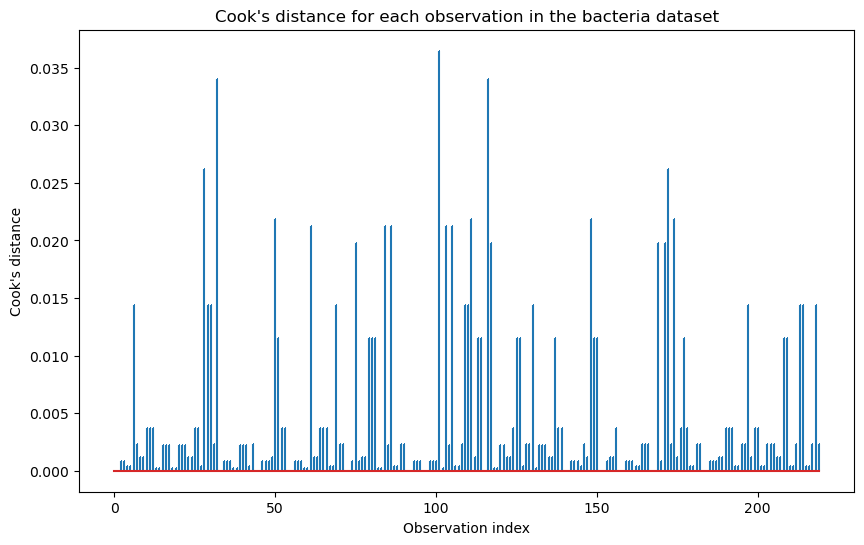

In [43]:
# Fit OLS model
ols_model = smf.ols(formula='y_int ~ ap + hilo + C(week_gt_2)', data=bacteria).fit()

# Calculate Cook's distance
influence = OLSInfluence(ols_model)
cooks = influence.cooks_distance

# Extracting the values and plotting Cook's distance
cooks_distance, p_values = cooks
fig, ax = plt.subplots(figsize=(10, 6))
ax.stem(cooks_distance, markerfmt=",")
ax.set_xlabel('Observation index')
ax.set_ylabel("Cook's distance")
ax.set_title("Cook's distance for each observation in the bacteria dataset")
plt.show()

### Observation
The plot displays Cook's distance, which is a measure of the influence of each data point. The maximum cook's distance is less than 0.04, thus indicates no potential influential points.

# GLMM - descriptive model

In [44]:
# Fit the GLMM models and print the summaries
import pymc3 as pm

In [45]:
bacteria_df = bacteria.copy()
ap_code = bacteria_df['ap'].astype('category').cat.codes.values
hilo_code = bacteria_df['hilo'].astype('category').cat.codes.values
week_gt_2 = (bacteria_df['week'] > 2).astype(int).values
y_int = bacteria_df['y_int'].values

# Combine the predictors into a single DataFrame
X = pd.DataFrame({'ap': ap_code, 'hilo': hilo_code, 'week_gt_2': week_gt_2})

# Define the model in PyMC3
with pm.Model() as model:
    # Set data container
    data_container = pm.Data("data", X)
    
    # Define GLM family
    family = pm.glm.families.Binomial()
    
    # Set priors
    priors = {
        "Intercept": pm.Normal.dist(mu=0, sd=10),
        "ap": pm.Normal.dist(mu=0, sd=10),
        "hilo": pm.Normal.dist(mu=0, sd=10),
        "week_gt_2": pm.Normal.dist(mu=0, sd=10)
    }
    labels = ["ap", "hilo", "week_gt_2"]
    # Specify model
    pm.GLM(y=y_int, x=data_container, family=family, labels=labels, priors=priors)
    
    # Configure sampler
    trace = pm.sample(5000, chains=5, tune=1000, target_accept=0.87)

/Users/kaywu/miniconda3/envs/torch/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [week_gt_2, hilo, ap, Intercept]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module na

/Users/kaywu/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kaywu/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kaywu/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kaywu/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kaywu/miniconda3/envs/torch/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 5_000 draw iterations (5_000

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/kaywu/miniconda3/envs/torch/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/kaywu/miniconda3/envs/torch/lib/python3.9/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'ap'}>, <Axes: title={'center': 'ap'}>],
       [<Axes: title={'center': 'hilo'}>,
        <Axes: title={'center': 'hilo'}>],
       [<Axes: title={'center': 'week_gt_2'}>,
        <Axes: title={'center': 'week_gt_2'}>]], dtype=object)

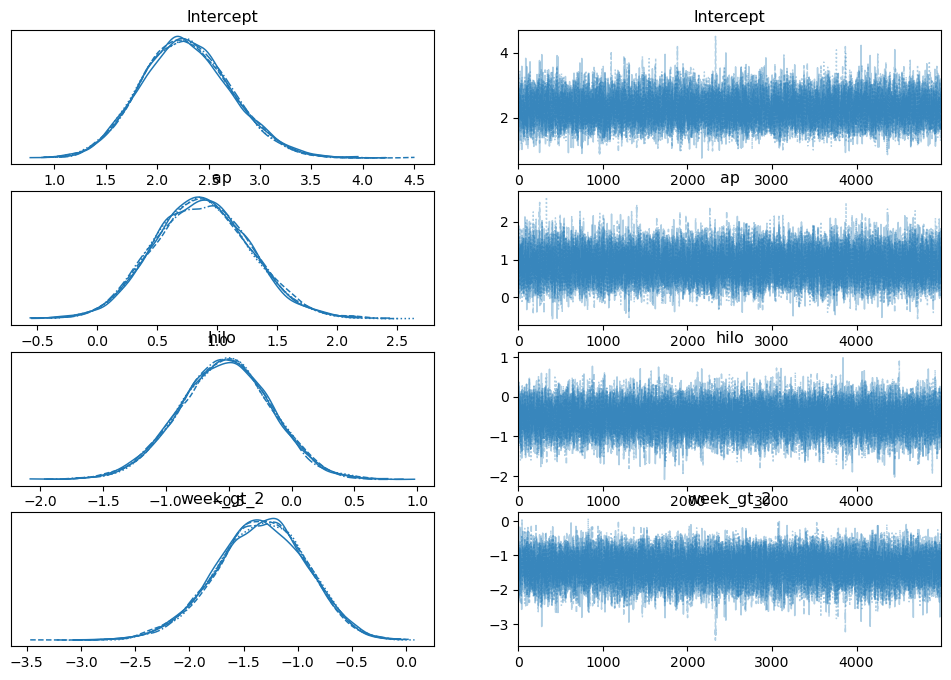

In [46]:
# Plot chains.
az.plot_trace(data=trace)

In [47]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/kaywu/miniconda3/envs/torch/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.284,0.438,1.477,3.110,0.004,0.003,10580.0,12503.0,1.0
ap,0.872,0.401,0.148,1.642,0.003,0.002,16205.0,14048.0,1.0
hilo,-0.529,0.366,-1.223,0.144,0.003,0.002,14442.0,14282.0,1.0
week_gt_2,-1.343,0.419,-2.147,-0.579,0.004,0.003,12657.0,13561.0,1.0


### Observation
The posterior distributions and trace plots reveal consistent patterns, suggesting a strong level of confidence in the estimated parameters of the model. The intercepts and slopes show a tendency to converge toward a uniform value, reflecting a consistent pattern of parameter stabilization as the model fitting progresses.
In a fixed effects model, the absolute values of the coefficients tend to be reduced, which leads to the odds ratios of each variable converging towards 1. This phenomenon underscores the importance of incorporating random effects to account for individual variability. Consequently, a generalized linear mixed model (GLMM), which includes both fixed and random effects, provides a more comprehensive and nuanced understanding of the data.

## Survival Analysis - Cox proportional hazards model

In [48]:
from lifelines import CoxPHFitter

In [49]:
bacteria['time'] = 1

In [50]:
cph = CoxPHFitter()
cph.fit(bacteria, 'time', 'y_int', strata=['ID'], formula = 'week')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 220 total observations, 43 right-censored observations>
             duration col = 'time'
                event col = 'y_int'
                   strata = ID
      baseline estimation = breslow
   number of observations = 220
number of events observed = 177
   partial log-likelihood = -177.95
         time fit was run = 2024-02-18 05:23:27 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
week       -0.03       0.97       0.02            -0.07             0.01                 0.93                 1.01

            cmp to     z    p   -log2(p)
covariate                               
week          0.00 -1.57 0.12       3.09
---
Concordance = 0.72
Partial AIC = 357.91
log-likelihood ratio test = 2.52 on 1 df
-log2(p) of ll-ratio test = 3.15

The result shows that each unit increase in 'week' is associated with a 3% decrease in the hazard of the event, while a p-value of 0.12 suggests that is not very significant.

In [51]:
cph = CoxPHFitter()
cph.fit(bacteria, 'time', 'y_int', strata=['ID'], formula = 'C(week)')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 220 total observations, 43 right-censored observations>
             duration col = 'time'
                event col = 'y_int'
                   strata = ID
      baseline estimation = breslow
   number of observations = 220
number of events observed = 177
   partial log-likelihood = -177.26
         time fit was run = 2024-02-18 05:23:27 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
C(week)[T.2]    0.04       1.05       0.22            -0.39             0.48                 0.68                 1.61
C(week)[T.4]   -0.25       0.78       0.24            -0.72             0.21                 0.49                 1.24
C(week)[T.6]   -0.30       0.74       0.24            -0.78             0.17                 0.46                 1.19
C(week)[T.11]  -0.28       0.75       0.24            -0.75             0.18                 0.47                 1.19

                cmp to     z    p   -log2(p)
covariate                                   
C(week)[T.2]      0.00  0.20 0.84       0.25
C(week)[T.4]      0.00 -1.07 0.29       1.80
C(week)[T.6]      0.00 -1.25 0.21       2.25
C(week)[T.11]     0.00 -1.21 0.23       2.14
---
Concordance = 0.72
Partial AIC = 362.52
log-likelihood ratio test = 3.91 on 4 df
-log2(p) of ll-ratio test = 1.26

### Observation
Except for week < 4, increase in 'week' will lead a decreas in the hazard of the event.

In [52]:
cph = CoxPHFitter()
cph.fit(bacteria, 'time', 'y_int', strata=['ID'], formula = 'week_gt_2')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 220 total observations, 43 right-censored observations>
             duration col = 'time'
                event col = 'y_int'
                   strata = ID
      baseline estimation = breslow
   number of observations = 220
number of events observed = 177
   partial log-likelihood = -177.30
         time fit was run = 2024-02-18 05:23:28 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
week_gt_2  -0.30       0.74       0.15            -0.60            -0.00                 0.55                 1.00

            cmp to     z    p   -log2(p)
covariate                               
week_gt_2     0.00 -1.96 0.05       4.34
---
Concordance = 0.72
Partial AIC = 356.59
log-likelihood ratio test = 3.83 on 1 df
-log2(p) of ll-ratio test = 4.31

### Observation
week_gt_2=1 is associated with a 26% reduction in the hazard of the event compared to week_gt_2=0, holding all other variables constant.

## Summary
- The drug is more effective than the placebo.
- The drug begins to show its effects after week 2, with a progressively increasing impact over time.
- The compliance effect may not enhance the drug's effectiveness and can occasionally diminish it.
- The GLMM model with predictors {ap + hilo + factor(I(week>2)) + (1|ID)} is considered the best model.

# Research Limitations and Recommendations for Future Research
- Research limitations include additional variables that could impact the outcome, such as patient age and pre-existing conditions, which were not considered in this study.
- The compliance method utilized in the study was found to be ineffective, contradicting common expectations. Future research should explore alternative methods to enhance drug efficacy.
- The dataset exhibits a gap in the {week} variable, jumping from week 6 to week 11 without clarification, raising questions about whether this gap was deliberate or an oversight.